In [1]:
from __future__ import division
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
import scipy.optimize as op
import xgboost as xgb
from sklearn.metrics import mean_squared_error,make_scorer,accuracy_score,recall_score,precision_score,roc_auc_score,roc_curve,auc,f1_score
from sklearn.model_selection import cross_val_score, KFold, cross_validate,StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit 
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn import metrics as metrices
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from statsmodels.stats.proportion import proportion_confint
from sklearn.preprocessing import StandardScaler
from mlxtend.evaluate import paired_ttest_5x2cv
import shap
%matplotlib inline

pd.options.display.float_format = '{:.3f}'.format
%config IPCompleter.greedy=True

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
afib_cohort = pd.read_csv('train_test/afib_diagnosis_pandas.csv',low_memory=False)


In [3]:
afib_diagnosis_pandas_limited = afib_cohort[['AGE_AT_INDEX','PT_SEX_CODE','FAM_HEART_HIST','FAM_STROKE_HIST','HYPERTENSION_AT_INDEX',
                                                               'MI_AT_INDEX','DIABETES_AT_INDEX','DYSLIPIDEMIA_AT_INDEX','CHF_AT_INDEX',
                                                               'HYPERCOAG_STATES_ALL_TIME','MILD_LIVER_DIS_AT_INDEX','MOD_SEV_LIVER_DIS_AT_INDEX',
                                                               'CHRONIC_LIVER_DIS_AT_INDEX','CHRONIC_LUNG_DIS_AT_INDEX','RHEUM_DIS_AT_INDEX',
                                                               'CHRONIC_KIDNEY_DIS_AT_INDEX','NEOPLASM_AT_INDEX','PERI_VASC_DIS_AT_INDEX',
                                                               'PFO_ALL_TIME','PAST_ISCHEMIC_STROKE_AT_INDEX','PAST_HEMORRHAGIC_STROKE_AT_INDEX',
                                                               'BMI_CLOSEST_TO_INDEX','HB_VALUE','PLT_VALUE','OBESITY_AT_INDEX','CAD_AT_INDEX','VHD_AT_INDEX','AFIB_DIAGNOSED']] 
afib_diagnosis_pandas_limited.info()
a = afib_diagnosis_pandas_limited.dropna(subset=['HB_VALUE','PLT_VALUE','BMI_CLOSEST_TO_INDEX'])
a.info()
a.to_csv('train_test/afib_diagnosis_pandas_ALL_variables.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1892 entries, 0 to 1891
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   AGE_AT_INDEX                      1892 non-null   float64
 1   PT_SEX_CODE                       1892 non-null   int64  
 2   FAM_HEART_HIST                    1892 non-null   int64  
 3   FAM_STROKE_HIST                   1892 non-null   int64  
 4   HYPERTENSION_AT_INDEX             1892 non-null   int64  
 5   MI_AT_INDEX                       1892 non-null   int64  
 6   DIABETES_AT_INDEX                 1892 non-null   int64  
 7   DYSLIPIDEMIA_AT_INDEX             1892 non-null   int64  
 8   CHF_AT_INDEX                      1892 non-null   int64  
 9   HYPERCOAG_STATES_ALL_TIME         1892 non-null   int64  
 10  MILD_LIVER_DIS_AT_INDEX           1892 non-null   int64  
 11  MOD_SEV_LIVER_DIS_AT_INDEX        1892 non-null   int64  
 12  CHRONI

In [4]:
from statsmodels.imputation import mice 
imp = mice.MICEData(afib_diagnosis_pandas_limited)
imp.update_all(10)
afib_diagnosis_pandas_limited = imp.data.copy()

In [5]:
scoring = {
    'auc':make_scorer(roc_auc_score),
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0),
    'ppv': make_scorer(precision_score),
    'npv': make_scorer(precision_score,pos_label=0)
}
kfold = StratifiedKFold(n_splits=5, shuffle=False)

In [6]:
import scipy.stats
from scipy import interp
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2, n-1)
    return  h


# Logistic regression

In [46]:
LR={'name':'LR','accuracy':[],'sensitivity':[], 'specificity':[],'auc':[],'ppv':[],'npv':[],'mean_tpr':[],'mean_auc':[],'F1':[]}
LR_havoc={'name':'LR_havoc','accuracy':[],'sensitivity':[], 'specificity':[],'auc':[],'ppv':[],'npv':[],'mean_tpr':[],'mean_auc':[],'F1':[]}
kfold = StratifiedKFold(n_splits=5, shuffle=False)
log_regression = LogisticRegression(solver='liblinear', C=.10,class_weight='balanced')
log_regression_havoc = LogisticRegression(solver='liblinear', C=10,class_weight='balanced')
X, y = afib_diagnosis_pandas_limited.iloc[:,:-1],afib_diagnosis_pandas_limited.iloc[:,-1]

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
mean_tpr_havoc = 0.0
mean_fpr_havoc = np.linspace(0, 1, 100)

list_shap_values = list()
list_test_sets = list()
list_shap_values_havoc = list()

for train_ix, test_ix in kfold.split(X,y):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
    stdSc = StandardScaler()
    X_tr = stdSc.fit_transform(X_train)
    X_tst = stdSc.transform(X_test)
    
    log_regression.fit(X_tr,y_train)
    prediction = log_regression.predict(X_tst)
    
    explainer = shap.LinearExplainer(log_regression, X_tr, feature_dependence="independent")
    shap_values = explainer.shap_values(X_tr)
    
    list_shap_values.append(shap_values)
    list_test_sets.append(train_ix)
    
    fpr, tpr, thresholds = roc_curve(y_test, prediction)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    #roc_auc = auc(fpr, tpr)
    
    LR['accuracy'].append(accuracy_score(y_test,prediction))
    LR['sensitivity'].append(recall_score(y_test,prediction))
    LR['specificity'].append(recall_score(y_test,prediction,pos_label=0))
    LR['auc'].append(roc_auc_score(y_test,prediction))
    LR['ppv'].append(precision_score(y_test,prediction))
    LR['npv'].append(precision_score(y_test,prediction,pos_label=0))
    LR['F1'].append(f1_score(y_test,prediction))
    
    X_train_havoc=X_train[['AGE_AT_INDEX','HYPERTENSION_AT_INDEX','VHD_AT_INDEX','PERI_VASC_DIS_AT_INDEX','CAD_AT_INDEX','OBESITY_AT_INDEX','CHF_AT_INDEX']]
    X_test_havoc=X_test[['AGE_AT_INDEX','HYPERTENSION_AT_INDEX','VHD_AT_INDEX','PERI_VASC_DIS_AT_INDEX','CAD_AT_INDEX','OBESITY_AT_INDEX','CHF_AT_INDEX']]
    
    X_tr_havoc = stdSc.fit_transform(X_train_havoc)
    X_tst_havoc = stdSc.transform(X_test_havoc)
        
    log_regression_havoc.fit(X_tr_havoc,y_train)
    prediction = log_regression_havoc.predict(X_tst_havoc)
    
    explainer_havoc = shap.LinearExplainer(log_regression_havoc, X_tr_havoc, feature_dependence="independent")
    shap_values_havoc = explainer.shap_values(X_tr_havoc)
    list_shap_values_havoc.append(shap_values_havoc)
    
    fpr_havoc, tpr_havoc, thresholds_havoc = roc_curve(y_test, prediction)
    mean_tpr_havoc += interp(mean_fpr_havoc, fpr_havoc, tpr_havoc)
    mean_tpr_havoc[0] = 0.0
    
    LR_havoc['accuracy'].append(accuracy_score(y_test,prediction))
    LR_havoc['sensitivity'].append(recall_score(y_test,prediction))
    LR_havoc['specificity'].append(recall_score(y_test,prediction,pos_label=0))
    LR_havoc['auc'].append(roc_auc_score(y_test,prediction))
    LR_havoc['ppv'].append(precision_score(y_test,prediction))
    LR_havoc['npv'].append(precision_score(y_test,prediction,pos_label=0))
    LR_havoc['F1'].append(f1_score(y_test,prediction))

mean_tpr /= kfold.get_n_splits(X, y)
mean_tpr[-1] = 1.0
LR['mean_auc'].append(auc(mean_fpr, mean_tpr))
LR['mean_tpr'].append(mean_tpr)


mean_tpr_havoc /= kfold.get_n_splits(X, y)
mean_tpr_havoc[-1] = 1.0
LR_havoc['mean_auc'].append(auc(mean_fpr_havoc, mean_tpr_havoc))
LR_havoc['mean_tpr'].append(mean_tpr_havoc)


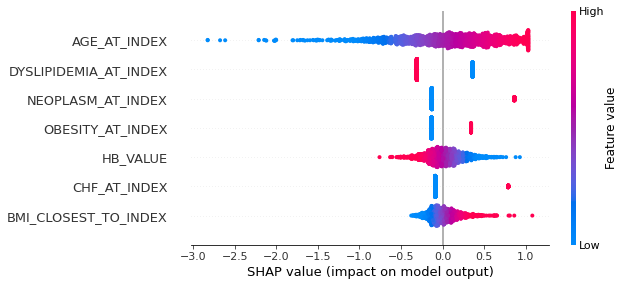

In [87]:
import shap

shap.initjs()

# explainer = shap.LinearExplainer(log_regression, X_tr, feature_dependence="independent")
# shap_values = explainer.shap_values(X_tr)
# shap.summary_plot(shap_values, X_tr, feature_names=X_train.columns,max_display=7, show= False)
# plt.savefig('LR_SHAP.pdf', dpi=300, format='pdf', bbox_inches='tight')

shapPlotforCV(list_test_sets,list_shap_values, X_tr,X_train.columns,"LR_SHAP")

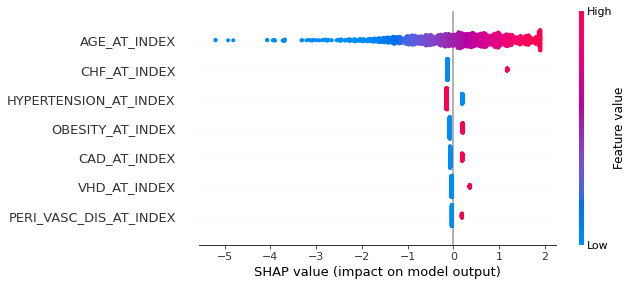

In [76]:
# shap.initjs()

# explainer = shap.LinearExplainer(log_regression_havoc, X_tr_havoc, feature_dependence="independent")
# shap_values = explainer.shap_values(X_tr_havoc)
# shap.summary_plot(shap_values, X_tr_havoc, feature_names=X_train_havoc.columns,show= False)
# plt.savefig('LR_havoc_SHAP.pdf', dpi=300, format='pdf', bbox_inches='tight')

shapPlotforCV(list_test_sets,list_shap_values_havoc, X_tr_havoc,X_train_havoc.columns,"LR_havoc_SHAP")

# Logistic regression Oversampled

In [47]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTENC
from collections import Counter

sm = SMOTENC(random_state=42, categorical_features=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,24,25,26])

LR_OS={'name':'LR_OS','accuracy':[],'sensitivity':[], 'specificity':[],'auc':[],'ppv':[],'npv':[],'mean_tpr':[],'mean_auc':[],'F1':[]}
LR_havoc_OS={'name':'LR_OS_havoc','accuracy':[],'sensitivity':[], 'specificity':[],'auc':[],'ppv':[],'npv':[],'mean_tpr':[],'mean_auc':[],'F1':[]}
log_regression = LogisticRegression(solver='liblinear', C=100)
log_regression_havoc = LogisticRegression(solver='liblinear', C=10)
X, y = afib_diagnosis_pandas_limited.iloc[:,:-1],afib_diagnosis_pandas_limited.iloc[:,-1]

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
mean_tpr_havoc = 0.0
mean_fpr_havoc = np.linspace(0, 1, 100)


list_shap_values = list()
list_test_sets = list()
list_shap_values_havoc = list()

for train_ix, test_ix in kfold.split(X,y):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
    X_train_os, y_train_os = sm.fit_resample(X, y)

    stdSc = StandardScaler()
    X_tr = stdSc.fit_transform(X_train_os)
    X_tst = stdSc.transform(X_test)
    
    log_regression.fit(X_tr,y_train)
    prediction = log_regression.predict(X_tst)
    
    explainer = shap.LinearExplainer(log_regression, X_tr, feature_dependence="independent")
    shap_values = explainer.shap_values(X_tr)
    
    list_shap_values.append(shap_values)
    list_test_sets.append(train_ix)
    
    fpr, tpr, thresholds = roc_curve(y_test, prediction)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    
    LR_OS['accuracy'].append(accuracy_score(y_test,prediction))
    LR_OS['sensitivity'].append(recall_score(y_test,prediction))
    LR_OS['specificity'].append(recall_score(y_test,prediction,pos_label=0))
    LR_OS['auc'].append(roc_auc_score(y_test,prediction))
    LR_OS['ppv'].append(precision_score(y_test,prediction))
    LR_OS['npv'].append(precision_score(y_test,prediction,pos_label=0))
    LR_OS['F1'].append(f1_score(y_test,prediction))
    
    X_train_havoc=X_train_os[['AGE_AT_INDEX','HYPERTENSION_AT_INDEX','VHD_AT_INDEX','PERI_VASC_DIS_AT_INDEX','CAD_AT_INDEX','OBESITY_AT_INDEX','CHF_AT_INDEX']]
    X_test_havoc=X_test[['AGE_AT_INDEX','HYPERTENSION_AT_INDEX','VHD_AT_INDEX','PERI_VASC_DIS_AT_INDEX','CAD_AT_INDEX','OBESITY_AT_INDEX','CHF_AT_INDEX']]
    
    X_tr_havoc = stdSc.fit_transform(X_train_havoc)
    X_tst_havoc = stdSc.transform(X_test_havoc)
    
    log_regression_havoc.fit(X_train_havoc,y_train_os)
    prediction = log_regression_havoc.predict(X_test_havoc)
    
    explainer_havoc = shap.LinearExplainer(log_regression_havoc, X_train_havoc, feature_dependence="independent")
    shap_values_havoc = explainer.shap_values(X_train_havoc)
    list_shap_values_havoc.append(shap_values_havoc)
    
    fpr_havoc, tpr_havoc, thresholds_havoc = roc_curve(y_test, prediction)
    mean_tpr_havoc += interp(mean_fpr_havoc, fpr_havoc, tpr_havoc)
    mean_tpr_havoc[0] = 0.0
    
    LR_havoc_OS['accuracy'].append(accuracy_score(y_test,prediction))
    LR_havoc_OS['sensitivity'].append(recall_score(y_test,prediction))
    LR_havoc_OS['specificity'].append(recall_score(y_test,prediction,pos_label=0))
    LR_havoc_OS['auc'].append(roc_auc_score(y_test,prediction))
    LR_havoc_OS['ppv'].append(precision_score(y_test,prediction))
    LR_havoc_OS['npv'].append(precision_score(y_test,prediction,pos_label=0))
    LR_havoc_OS['F1'].append(f1_score(y_test,prediction))

mean_tpr /= kfold.get_n_splits(X, y)
mean_tpr[-1] = 1.0
LR_OS['mean_auc'].append(auc(mean_fpr, mean_tpr))
LR_OS['mean_tpr'].append(mean_tpr)


mean_tpr_havoc /= kfold.get_n_splits(X, y)
mean_tpr_havoc[-1] = 1.0
LR_havoc_OS['mean_auc'].append(auc(mean_fpr_havoc, mean_tpr_havoc))
LR_havoc_OS['mean_tpr'].append(mean_tpr_havoc)

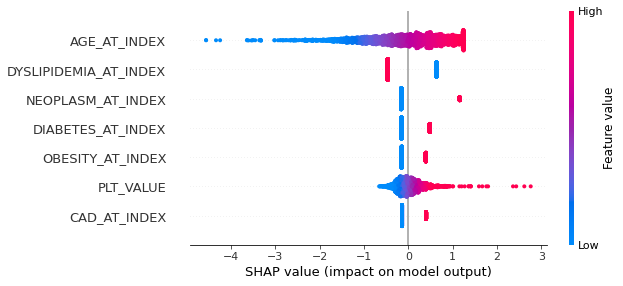

In [92]:
import shap

# shap.initjs()

# explainer = shap.LinearExplainer(log_regression, X_train_os, feature_dependence="independent")
# shap_values = explainer.shap_values(X_train_os)
# shap.summary_plot(shap_values, X_train_os, feature_names=X_train_os.columns,max_display=7, show= False)
# plt.savefig('LR_OS_SHAP.pdf', dpi=300, format='pdf', bbox_inches='tight')
shapPlotforCV(list_test_sets,list_shap_values, X_tr,X_train_os.columns,"LR_OS_SHAP")

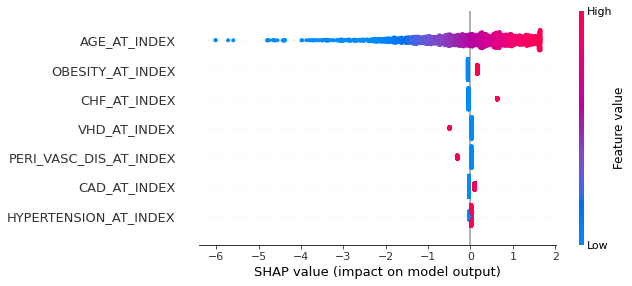

In [95]:
# shap.initjs()

# explainer = shap.LinearExplainer(log_regression_havoc, X_train_havoc, feature_dependence="independent")
# shap_values = explainer.shap_values(X_train_havoc)
# shap.summary_plot(shap_values, X_train_havoc, feature_names=X_train_havoc.columns,show= False)
# plt.savefig('LR_OS_havoc_SHAP.pdf', dpi=300, format='pdf', bbox_inches='tight')

shapPlotforCV(list_test_sets,list_shap_values_havoc, X_tr_havoc,X_train_havoc.columns,"LR_OS_havoc_SHAP")

# Xg boost

In [48]:
from sklearn.utils import class_weight
import warnings; warnings.simplefilter('ignore')
XGB={'name':'XGB','accuracy':[],'sensitivity':[], 'specificity':[],'auc':[],'ppv':[],'npv':[],'mean_tpr':[],'mean_auc':[],'F1':[]}
XGB_havoc={'name':'XGB_havoc','accuracy':[],'sensitivity':[], 'specificity':[],'auc':[],'ppv':[],'npv':[],'mean_tpr':[],'mean_auc':[],'F1':[]}

clf = xgb.XGBClassifier(n_estimators=100, max_depth=10, objective='binary:logistic',
            seed=123, nthread=-1, learning_rate=0.01,min_child_weight=5)

clf_havoc = xgb.XGBClassifier(n_estimators=50, max_depth=30, objective='binary:logistic',
            seed=123, nthread=-1, learning_rate=0.1,min_child_weight=10)

X, y = afib_diagnosis_pandas_limited.iloc[:,:-1],afib_diagnosis_pandas_limited.iloc[:,-1]

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
mean_tpr_havoc = 0.0
mean_fpr_havoc = np.linspace(0, 1, 100)

list_shap_values = list()
list_test_sets = list()
list_shap_values_havoc = list()

for train_ix, test_ix in kfold.split(X,y):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
    class_weights = list(class_weight.compute_class_weight('balanced',np.unique(y_train),y_train))
    w_array = np.ones(y_train.shape[0], dtype = 'float')
    for i, val in enumerate(y_train):
        w_array[i] = class_weights[val]
    
    clf.fit(X_train,y_train,sample_weight = w_array)
    prediction = clf.predict(X_test)
    
    
    explainer = shap.TreeExplainer(clf, X_train, feature_names=X_train.columns,feature_dependence="independent")
    shap_values = explainer.shap_values(X_tr)
    
    list_shap_values.append(shap_values)
    list_test_sets.append(train_ix)
    
    fpr, tpr, thresholds = roc_curve(y_test, prediction)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    
    XGB['accuracy'].append(accuracy_score(y_test,prediction))
    XGB['sensitivity'].append(recall_score(y_test,prediction))
    XGB['specificity'].append(recall_score(y_test,prediction,pos_label=0))
    XGB['auc'].append(roc_auc_score(y_test,prediction))
    XGB['ppv'].append(precision_score(y_test,prediction))
    XGB['npv'].append(precision_score(y_test,prediction,pos_label=0))
    XGB['F1'].append(f1_score(y_test,prediction))
    
    X_train_havoc=X_train[['AGE_AT_INDEX','HYPERTENSION_AT_INDEX','VHD_AT_INDEX','PERI_VASC_DIS_AT_INDEX','CAD_AT_INDEX','OBESITY_AT_INDEX','CHF_AT_INDEX']]
    X_test_havoc=X_test[['AGE_AT_INDEX','HYPERTENSION_AT_INDEX','VHD_AT_INDEX','PERI_VASC_DIS_AT_INDEX','CAD_AT_INDEX','OBESITY_AT_INDEX','CHF_AT_INDEX']]
    
    clf_havoc.fit(X_train_havoc,y_train,sample_weight = w_array)
    prediction = clf_havoc.predict(X_test_havoc)
    
    explainer_havoc = shap.TreeExplainer(clf_havoc, X_train_havoc, feature_names=X_train_havoc.columns,feature_dependence="independent")
    shap_values_havoc = explainer.shap_values(X_train_havoc)
    list_shap_values_havoc.append(shap_values_havoc)
    
    fpr_havoc, tpr_havoc, thresholds_havoc = roc_curve(y_test, prediction)
    mean_tpr_havoc += interp(mean_fpr_havoc, fpr_havoc, tpr_havoc)
    mean_tpr_havoc[0] = 0.0
    
    XGB_havoc['accuracy'].append(accuracy_score(y_test,prediction))
    XGB_havoc['sensitivity'].append(recall_score(y_test,prediction))
    XGB_havoc['specificity'].append(recall_score(y_test,prediction,pos_label=0))
    XGB_havoc['auc'].append(roc_auc_score(y_test,prediction))
    XGB_havoc['ppv'].append(precision_score(y_test,prediction))
    XGB_havoc['npv'].append(precision_score(y_test,prediction,pos_label=0))
    XGB_havoc['F1'].append(f1_score(y_test,prediction))
    

mean_tpr /= kfold.get_n_splits(X, y)
mean_tpr[-1] = 1.0
XGB['mean_auc'].append(auc(mean_fpr, mean_tpr))
XGB['mean_tpr'].append(mean_tpr)


mean_tpr_havoc /= kfold.get_n_splits(X, y)
mean_tpr_havoc[-1] = 1.0
XGB_havoc['mean_auc'].append(auc(mean_fpr_havoc, mean_tpr_havoc))
XGB_havoc['mean_tpr'].append(mean_tpr_havoc)    

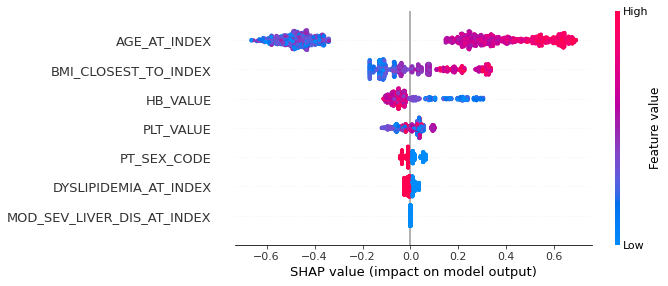

In [98]:
# explainer = shap.TreeExplainer(clf, X_train, feature_names=X_train.columns,feature_dependence="independent")
# shap_values = explainer.shap_values(X_train)
# shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns,max_display=7, show= False)
# plt.savefig('XGB_SHAP.pdf', dpi=300, format='pdf', bbox_inches='tight')
shapPlotforCV(list_test_sets,list_shap_values, X_train,X_train.columns,"XGB")

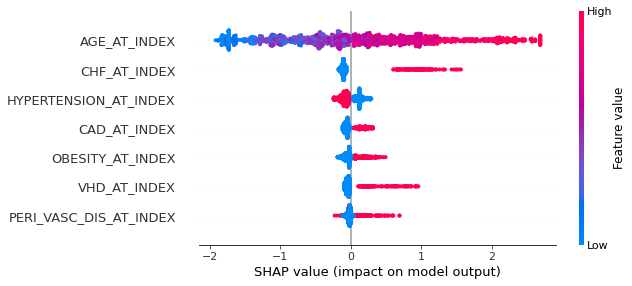

In [102]:
# explainer = shap.TreeExplainer(clf_havoc, X_train_havoc, feature_names=X_train_havoc.columns,feature_dependence="independent")
# shap_values = explainer.shap_values(X_train_havoc)
# shap.summary_plot(shap_values, features=X_train_havoc, feature_names=X_train_havoc.columns,max_display=7, show= False)
# plt.savefig('XGB_havoc_SHAP.pdf', dpi=300, format='pdf', bbox_inches='tight')

shapPlotforCV(list_test_sets,list_shap_values_havoc, X_train_havoc,X_train_havoc.columns,"XGB_havoc_SHAP")

# SVM

In [49]:
clf = SVC(kernel='linear', class_weight='balanced',gamma = 'scale',probability=True)
clf_havoc = SVC(kernel='linear', class_weight='balanced',gamma = 'scale',probability=True)

SV={'name':'SVM(L)','accuracy':[],'sensitivity':[], 'specificity':[],'auc':[],'ppv':[],'npv':[],'mean_tpr':[],'mean_auc':[],'F1':[]}
SV_havoc={'name':'SVM_havoc(L)','accuracy':[],'sensitivity':[], 'specificity':[],'auc':[],'ppv':[],'npv':[],'mean_tpr':[],'mean_auc':[],'F1':[]}

X, y = afib_diagnosis_pandas_limited.iloc[:,:-1],afib_diagnosis_pandas_limited.iloc[:,-1]

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
mean_tpr_havoc = 0.0
mean_fpr_havoc = np.linspace(0, 1, 100)

list_shap_values = list()
list_test_sets = list()
list_test_sets_havoc= list()
list_shap_values_havoc = list()

for train_ix, test_ix in kfold.split(X,y):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
    clf.fit(X_train,y_train)
    prediction = clf.predict(X_test)
    
    X100 = shap.utils.sample(X_train, 100)
    explainer = shap.KernelExplainer(model=clf.predict_proba, data=X100,feature_names=X100.columns,feature_dependence="independent")
    shap_values = explainer.shap_values(X100)
    
    list_shap_values.append(shap_values)
    list_test_sets.append(list(X100.index))
    
    fpr, tpr, thresholds = roc_curve(y_test, prediction)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    
    SV['accuracy'].append(accuracy_score(y_test,prediction))
    SV['sensitivity'].append(recall_score(y_test,prediction))
    SV['specificity'].append(recall_score(y_test,prediction,pos_label=0))
    SV['auc'].append(roc_auc_score(y_test,prediction))
    SV['ppv'].append(precision_score(y_test,prediction))
    SV['npv'].append(precision_score(y_test,prediction,pos_label=0))
    SV['F1'].append(f1_score(y_test,prediction))
    
    X_train_havoc=X_train[['AGE_AT_INDEX','HYPERTENSION_AT_INDEX','VHD_AT_INDEX','PERI_VASC_DIS_AT_INDEX','CAD_AT_INDEX','OBESITY_AT_INDEX','CHF_AT_INDEX']]
    X_test_havoc=X_test[['AGE_AT_INDEX','HYPERTENSION_AT_INDEX','VHD_AT_INDEX','PERI_VASC_DIS_AT_INDEX','CAD_AT_INDEX','OBESITY_AT_INDEX','CHF_AT_INDEX']]
    
    clf_havoc.fit(X_train_havoc,y_train)
    prediction = clf_havoc.predict(X_test_havoc)
    
    X100 = shap.utils.sample(X_train_havoc, 100)
    explainer = shap.KernelExplainer(model=clf_havoc.predict_proba, data=X100, link="logit",feature_names=X100.columns,feature_dependence="independent")
    shap_values_havoc = explainer.shap_values(X100)
    list_shap_values_havoc.append(shap_values_havoc)
    list_test_sets_havoc.append(list(X100.index))
    
    fpr_havoc, tpr_havoc, thresholds_havoc = roc_curve(y_test, prediction)
    mean_tpr_havoc += interp(mean_fpr_havoc, fpr_havoc, tpr_havoc)
    mean_tpr_havoc[0] = 0.0
    
    SV_havoc['accuracy'].append(accuracy_score(y_test,prediction))
    SV_havoc['sensitivity'].append(recall_score(y_test,prediction))
    SV_havoc['specificity'].append(recall_score(y_test,prediction,pos_label=0))
    SV_havoc['auc'].append(roc_auc_score(y_test,prediction))
    SV_havoc['ppv'].append(precision_score(y_test,prediction))
    SV_havoc['npv'].append(precision_score(y_test,prediction,pos_label=0))
    SV_havoc['F1'].append(f1_score(y_test,prediction))
    
mean_tpr /= kfold.get_n_splits(X, y)
mean_tpr[-1] = 1.0
SV['mean_auc'].append(auc(mean_fpr, mean_tpr))
SV['mean_tpr'].append(mean_tpr)


mean_tpr_havoc /= kfold.get_n_splits(X, y)
mean_tpr_havoc[-1] = 1.0
SV_havoc['mean_auc'].append(auc(mean_fpr_havoc, mean_tpr_havoc))
SV_havoc['mean_tpr'].append(mean_tpr_havoc)    

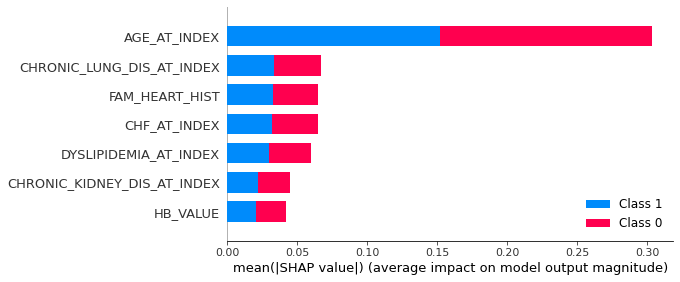

In [120]:
probability=True
X100 = shap.utils.sample(X_train, 100)
explainer = shap.KernelExplainer(model=clf.predict_proba, data=X100,feature_names=X100.columns,feature_dependence="independent")
shap_values = explainer.shap_values(X100)
shap.summary_plot(shap_values, X100, feature_names=X100.columns,max_display=7, show= False)

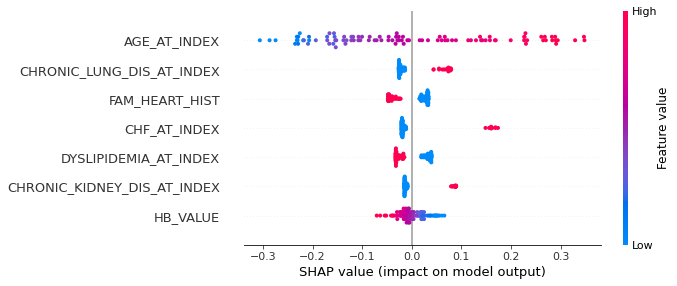

In [130]:
# shap.summary_plot(shap_values[1], X100, feature_names=X100.columns,max_display=7, show= False,plot_type='dot')
# plt.savefig('SVM_SHAP.pdf', dpi=300, format='pdf', bbox_inches='tight')
shapPlotforCV(list_test_sets,list_shap_values, X_train,X_train.columns,"SVM_SHAP")

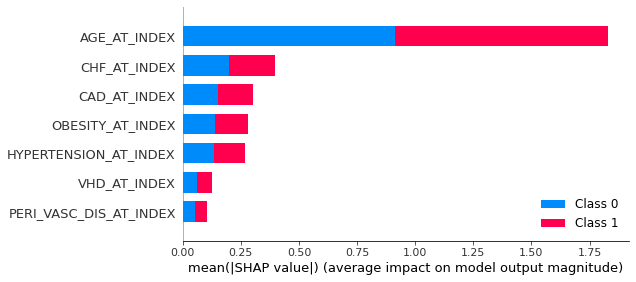

In [131]:
X100 = shap.utils.sample(X_train_havoc, 100)
explainer = shap.KernelExplainer(model=clf_havoc.predict_proba, data=X100, link="logit",feature_names=X100.columns,feature_dependence="independent")
shap_values = explainer.shap_values(X100)
shap.summary_plot(shap_values, features=X100, feature_names=X100.columns,max_display=7, show= False)

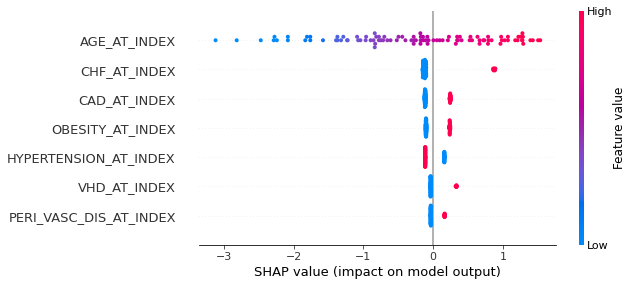

In [132]:
# shap.summary_plot(shap_values[1], X100, feature_names=X100.columns,max_display=7, show= False,plot_type='dot')
# plt.savefig('SVM_HAVOC_SHAP.pdf', dpi=300, format='pdf', bbox_inches='tight')
shapPlotforCV(list_test_sets_havoc,list_shap_values_havoc, X_train_havoc,X_train_havoc.columns,"SVM_havoc_SHAP")

# SVM Gauss

In [50]:
clf = SVC(kernel= 'rbf',class_weight='balanced', gamma = 'scale',C=10,probability=True)
clf_havoc = SVC(kernel= 'rbf',class_weight='balanced',gamma = 'scale',C=10,probability=True)

SVG={'name':'SVM(G)','accuracy':[],'sensitivity':[], 'specificity':[],'auc':[],'ppv':[],'npv':[],'mean_tpr':[],'mean_auc':[],'F1':[]}
SVG_havoc={'name':'SVM_havoc(G)','accuracy':[],'sensitivity':[], 'specificity':[],'auc':[],'ppv':[],'npv':[],'mean_tpr':[],'mean_auc':[],'F1':[]}

X, y = afib_diagnosis_pandas_limited.iloc[:,:-1],afib_diagnosis_pandas_limited.iloc[:,-1]

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
mean_tpr_havoc = 0.0
mean_fpr_havoc = np.linspace(0, 1, 100)

list_shap_values = list()
list_test_sets = list()
list_test_sets_havoc= list()
list_shap_values_havoc = list()

for train_ix, test_ix in kfold.split(X,y):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
    clf.fit(X_train,y_train)
    prediction = clf.predict(X_test)
    
    X100 = shap.utils.sample(X_train, 100)
    explainer = shap.KernelExplainer(model=clf.predict_proba, data=X100,feature_names=X100.columns,feature_dependence="independent")
    shap_values = explainer.shap_values(X100)
    
    list_shap_values.append(shap_values)
    list_test_sets.append(list(X100.index))
    
    fpr, tpr, thresholds = roc_curve(y_test, prediction)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    
    SVG['accuracy'].append(accuracy_score(y_test,prediction))
    SVG['sensitivity'].append(recall_score(y_test,prediction))
    SVG['specificity'].append(recall_score(y_test,prediction,pos_label=0))
    SVG['auc'].append(roc_auc_score(y_test,prediction))
    SVG['ppv'].append(precision_score(y_test,prediction))
    SVG['npv'].append(precision_score(y_test,prediction,pos_label=0))
    SVG['F1'].append(f1_score(y_test,prediction))
    
    X_train_havoc=X_train[['AGE_AT_INDEX','HYPERTENSION_AT_INDEX','VHD_AT_INDEX','PERI_VASC_DIS_AT_INDEX','CAD_AT_INDEX','OBESITY_AT_INDEX','CHF_AT_INDEX']]
    X_test_havoc=X_test[['AGE_AT_INDEX','HYPERTENSION_AT_INDEX','VHD_AT_INDEX','PERI_VASC_DIS_AT_INDEX','CAD_AT_INDEX','OBESITY_AT_INDEX','CHF_AT_INDEX']]
    
    clf_havoc.fit(X_train_havoc,y_train)
    prediction = clf_havoc.predict(X_test_havoc)
    
    fpr_havoc, tpr_havoc, thresholds_havoc = roc_curve(y_test, prediction)
    mean_tpr_havoc += interp(mean_fpr_havoc, fpr_havoc, tpr_havoc)
    mean_tpr_havoc[0] = 0.0
    
    X100 = shap.utils.sample(X_train_havoc, 100)
    explainer = shap.KernelExplainer(model=clf_havoc.predict_proba, data=X100, link="logit",feature_names=X100.columns,feature_dependence="independent")
    shap_values_havoc = explainer.shap_values(X100)
    list_shap_values_havoc.append(shap_values_havoc)
    list_test_sets_havoc.append(list(X100.index))
    
    SVG_havoc['accuracy'].append(accuracy_score(y_test,prediction))
    SVG_havoc['sensitivity'].append(recall_score(y_test,prediction))
    SVG_havoc['specificity'].append(recall_score(y_test,prediction,pos_label=0))
    SVG_havoc['auc'].append(roc_auc_score(y_test,prediction))
    SVG_havoc['ppv'].append(precision_score(y_test,prediction))
    SVG_havoc['npv'].append(precision_score(y_test,prediction,pos_label=0))
    SVG_havoc['F1'].append(f1_score(y_test,prediction))

mean_tpr /= kfold.get_n_splits(X, y)
mean_tpr[-1] = 1.0
SVG['mean_auc'].append(auc(mean_fpr, mean_tpr))
SVG['mean_tpr'].append(mean_tpr)


mean_tpr_havoc /= kfold.get_n_splits(X, y)
mean_tpr_havoc[-1] = 1.0
SVG_havoc['mean_auc'].append(auc(mean_fpr_havoc, mean_tpr_havoc))
SVG_havoc['mean_tpr'].append(mean_tpr_havoc)        

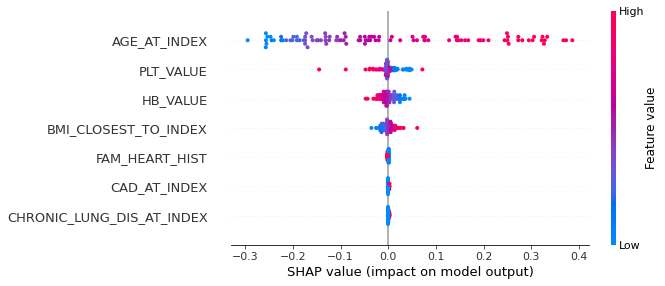

In [137]:
# X100 = shap.utils.sample(X_train, 100)
# X_train_summary = shap.kmeans(X_train, 100)
# explainer = shap.KernelExplainer(model=clf.predict_proba, data=X100,feature_names=X100.columns,feature_dependence="independent")
# shap_values = explainer.shap_values(X100)
# shap.summary_plot(shap_values[1], X100, feature_names=X100.columns,max_display=7, show= False,plot_type='dot')
# plt.savefig('SVM_GAUSS_SHAP.pdf', dpi=300, format='pdf', bbox_inches='tight')
shapPlotforCV(list_test_sets,list_shap_values, X_train,X_train.columns,"SVM_GAUSS_SHAP")

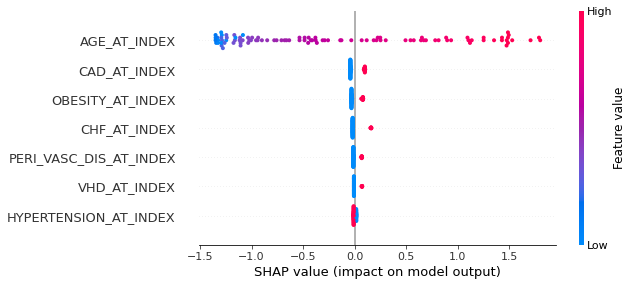

In [138]:
# X100 = shap.utils.sample(X_train_havoc, 100)
# explainer = shap.KernelExplainer(model=clf_havoc.predict_proba, data=X100, link="logit",feature_names=X100.columns,feature_dependence="independent")
# shap_values = explainer.shap_values(X100)
# shap.summary_plot(shap_values[1], X100, feature_names=X100.columns,max_display=7, show= False,plot_type='dot')
# plt.savefig('SVM_GAUSS_HAVOC_SHAP.pdf', dpi=300, format='pdf', bbox_inches='tight')
shapPlotforCV(list_test_sets_havoc,list_shap_values_havoc, X_train_havoc,X_train_havoc.columns,"SVM_GAUSS_HAVOC_SHAP")

# catboost

In [ ]:
import catboost as cb
categorical_features=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,24,25,26]
categorical_features_havoc=[1,2,3,4,5,6]

CB={'name':'CB','accuracy':[],'sensitivity':[], 'specificity':[],'auc':[],'ppv':[],'npv':[],'mean_tpr':[],'mean_auc':[],'F1':[]}
CB_havoc={'name':'CB_havoc','accuracy':[],'sensitivity':[], 'specificity':[],'auc':[],'ppv':[],'npv':[],'mean_tpr':[],'mean_auc':[],'F1':[]}
clf = cb.CatBoostClassifier(one_hot_max_size=31, depth=10, iterations= 500, l2_leaf_reg= 9, learning_rate= 0.05)
clf_havoc = cb.CatBoostClassifier(one_hot_max_size=31, depth=10, iterations= 500, l2_leaf_reg= 9, learning_rate= 0.05)

X, y = afib_diagnosis_pandas_limited.iloc[:,:-1],afib_diagnosis_pandas_limited.iloc[:,-1]

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
mean_tpr_havoc = 0.0
mean_fpr_havoc = np.linspace(0, 1, 100)

list_shap_values = list()
list_test_sets = list()
list_shap_values_havoc = list()

for train_ix, test_ix in kfold.split(X,y):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
    class_weights = list(class_weight.compute_class_weight('balanced',np.unique(y_train),y_train))
    w_array = np.ones(y_train.shape[0], dtype = 'float')
    for i, val in enumerate(y_train):
        w_array[i] = class_weights[val]
    
    clf.fit(X_train,y_train, cat_features= categorical_features,sample_weight = w_array)
    prediction = clf.predict(X_test)
    
    explainer = shap.TreeExplainer(clf, X_train, feature_names=X_train.columns,feature_dependence="independent")
    shap_values = explainer.shap_values(X_tr)
    
    list_shap_values.append(shap_values)
    list_test_sets.append(train_ix)
    
    fpr, tpr, thresholds = roc_curve(y_test, prediction)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    
    CB['accuracy'].append(accuracy_score(y_test,prediction))
    CB['sensitivity'].append(recall_score(y_test,prediction))
    CB['specificity'].append(recall_score(y_test,prediction,pos_label=0))
    CB['auc'].append(roc_auc_score(y_test,prediction))
    CB['ppv'].append(precision_score(y_test,prediction))
    CB['npv'].append(precision_score(y_test,prediction,pos_label=0))
    CB['F1'].append(f1_score(y_test,prediction))
    
    X_train_havoc=X_train[['AGE_AT_INDEX','HYPERTENSION_AT_INDEX','VHD_AT_INDEX','PERI_VASC_DIS_AT_INDEX','CAD_AT_INDEX','OBESITY_AT_INDEX','CHF_AT_INDEX']]
    X_test_havoc=X_test[['AGE_AT_INDEX','HYPERTENSION_AT_INDEX','VHD_AT_INDEX','PERI_VASC_DIS_AT_INDEX','CAD_AT_INDEX','OBESITY_AT_INDEX','CHF_AT_INDEX']]
    
    clf_havoc.fit(X_train_havoc,y_train,cat_features= categorical_features_havoc,sample_weight = w_array)
    prediction = clf_havoc.predict(X_test_havoc)
    
    explainer_havoc = shap.TreeExplainer(clf_havoc, X_train_havoc, feature_names=X_train_havoc.columns,feature_dependence="independent")
    shap_values_havoc = explainer.shap_values(X_train_havoc)
    list_shap_values_havoc.append(shap_values_havoc)
    
    fpr_havoc, tpr_havoc, thresholds_havoc = roc_curve(y_test, prediction)
    mean_tpr_havoc += interp(mean_fpr_havoc, fpr_havoc, tpr_havoc)
    mean_tpr_havoc[0] = 0.0
    
    CB_havoc['accuracy'].append(accuracy_score(y_test,prediction))
    CB_havoc['sensitivity'].append(recall_score(y_test,prediction))
    CB_havoc['specificity'].append(recall_score(y_test,prediction,pos_label=0))
    CB_havoc['auc'].append(roc_auc_score(y_test,prediction))
    CB_havoc['ppv'].append(precision_score(y_test,prediction))
    CB_havoc['npv'].append(precision_score(y_test,prediction,pos_label=0))
    CB_havoc['F1'].append(f1_score(y_test,prediction))
    
mean_tpr /= kfold.get_n_splits(X, y)
mean_tpr[-1] = 1.0
CB['mean_auc'].append(auc(mean_fpr, mean_tpr))
CB['mean_tpr'].append(mean_tpr)


mean_tpr_havoc /= kfold.get_n_splits(X, y)
mean_tpr_havoc[-1] = 1.0
CB_havoc['mean_auc'].append(auc(mean_fpr_havoc, mean_tpr_havoc))
CB_havoc['mean_tpr'].append(mean_tpr_havoc)    

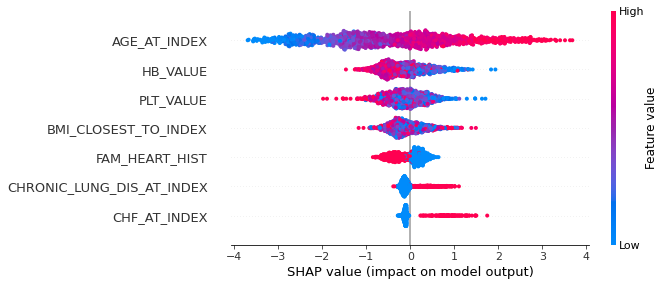

In [146]:
# explainer = shap.TreeExplainer(clf)
# shap_values = explainer.shap_values(X_train)
# shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns,max_display=7, show= False)
# plt.savefig('CB_SHAP.pdf', dpi=300, format='pdf', bbox_inches='tight')

shapPlotforCV(list_test_sets,list_shap_values, X_train,X_train.columns,"CB_SHAP")

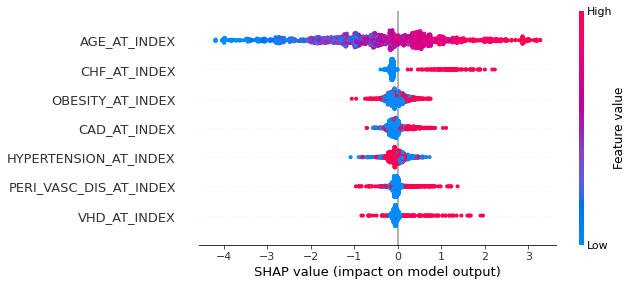

In [147]:
# explainer = shap.TreeExplainer(clf_havoc)
# shap_values = explainer.shap_values(X_train_havoc)
# shap.summary_plot(shap_values, features=X_train_havoc, feature_names=X_train_havoc.columns,max_display=7, show= False)
# plt.savefig('CB_HAVOC_SHAP.pdf', dpi=300, format='pdf', bbox_inches='tight')

shapPlotforCV(list_test_sets,list_shap_values_havoc, X_train_havoc,X_train_havoc.columns,"CB_havoc_SHAP")

# Neural net

In [52]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

NN={'name':'NN','accuracy':[],'sensitivity':[], 'specificity':[],'auc':[],'ppv':[],'npv':[],'mean_tpr':[],'mean_auc':[],'F1':[]}
NN_havoc={'name':'NN_havoc','accuracy':[],'sensitivity':[], 'specificity':[],'auc':[],'ppv':[],'npv':[],'mean_tpr':[],'mean_auc':[],'F1':[]}
mlp = MLPClassifier(hidden_layer_sizes=(14),max_iter=500,activation='logistic', solver='adam')
mlp_havoc = MLPClassifier(hidden_layer_sizes=(4),max_iter=500,activation='logistic', solver='adam')
X, y = afib_diagnosis_pandas_limited.iloc[:,:-1],afib_diagnosis_pandas_limited.iloc[:,-1]

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
mean_tpr_havoc = 0.0
mean_fpr_havoc = np.linspace(0, 1, 100)

list_shap_values = list()
list_test_sets = list()
list_test_sets_havoc= list()
list_shap_values_havoc = list()

for train_ix, test_ix in kfold.split(X,y):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    #print(X_train.shape)
    X_train_os, y_train_os = sm.fit_resample(X, y)
    X_train_Havoc = X_train_os[['AGE_AT_INDEX','HYPERTENSION_AT_INDEX','VHD_AT_INDEX','PERI_VASC_DIS_AT_INDEX','CAD_AT_INDEX','OBESITY_AT_INDEX','CHF_AT_INDEX']]
 
    scaler = StandardScaler()
    scaler.fit(X_train_os)
    
    X_train_new = scaler.transform(X_train_os)
    X_test_new = scaler.transform(X_test)
    
    mlp.fit(X_train_new,y_train_os)
    prediction = mlp.predict(X_test_new)
    
    X100 = shap.utils.sample(X_train_new, 100)
    explainer = shap.KernelExplainer(model=mlp.predict_proba, data=X100,feature_names=X_train.columns,feature_dependence="independent")
    shap_values = explainer.shap_values(X100)
    
    list_shap_values.append(shap_values)
    list_test_sets.append(list(X100.index))
    
    fpr, tpr, thresholds = roc_curve(y_test, prediction)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    
    NN['accuracy'].append(accuracy_score(y_test,prediction))
    NN['sensitivity'].append(recall_score(y_test,prediction))
    NN['specificity'].append(recall_score(y_test,prediction,pos_label=0))
    NN['auc'].append(roc_auc_score(y_test,prediction))
    NN['ppv'].append(precision_score(y_test,prediction))
    NN['npv'].append(precision_score(y_test,prediction,pos_label=0))
    NN['F1'].append(f1_score(y_test,prediction))
    
    X_train_havoc=X_train_os[['AGE_AT_INDEX','HYPERTENSION_AT_INDEX','VHD_AT_INDEX','PERI_VASC_DIS_AT_INDEX','CAD_AT_INDEX','OBESITY_AT_INDEX','CHF_AT_INDEX']]
    X_test_havoc=X_test[['AGE_AT_INDEX','HYPERTENSION_AT_INDEX','VHD_AT_INDEX','PERI_VASC_DIS_AT_INDEX','CAD_AT_INDEX','OBESITY_AT_INDEX','CHF_AT_INDEX']]
    
    scaler_havoc = StandardScaler()
    scaler_havoc.fit(X_train_havoc)
    X_test_havoc = scaler_havoc.transform(X_test_havoc)
    X_train_havoc = scaler_havoc.transform(X_train_havoc)

    mlp_havoc.fit(X_train_havoc,y_train_os)
    prediction = mlp_havoc.predict(X_test_havoc)
    
    X100 = shap.utils.sample(X_train_havoc, 100)
    explainer = shap.KernelExplainer(model=mlp_havoc.predict_proba, data=X100, link="logit",feature_names=X_train_havoc.columns,feature_dependence="independent")
    shap_values_havoc = explainer.shap_values(X100)
    list_shap_values_havoc.append(shap_values_havoc)
    list_test_sets_havoc.append(list(X100.index))
    
    fpr_havoc, tpr_havoc, thresholds_havoc = roc_curve(y_test, prediction)
    mean_tpr_havoc += interp(mean_fpr_havoc, fpr_havoc, tpr_havoc)
    mean_tpr_havoc[0] = 0.0
    
    NN_havoc['accuracy'].append(accuracy_score(y_test,prediction))
    NN_havoc['sensitivity'].append(recall_score(y_test,prediction))
    NN_havoc['specificity'].append(recall_score(y_test,prediction,pos_label=0))
    NN_havoc['auc'].append(roc_auc_score(y_test,prediction))
    NN_havoc['ppv'].append(precision_score(y_test,prediction))
    NN_havoc['npv'].append(precision_score(y_test,prediction,pos_label=0))
    NN_havoc['F1'].append(f1_score(y_test,prediction))
    
mean_tpr /= kfold.get_n_splits(X, y)
mean_tpr[-1] = 1.0
NN['mean_auc'].append(auc(mean_fpr, mean_tpr))
NN['mean_tpr'].append(mean_tpr)


mean_tpr_havoc /= kfold.get_n_splits(X, y)
mean_tpr_havoc[-1] = 1.0
NN_havoc['mean_auc'].append(auc(mean_fpr_havoc, mean_tpr_havoc))
NN_havoc['mean_tpr'].append(mean_tpr_havoc)      

$$N_{h} = \frac{N_{s}} {(\alpha * (N_{i} + N_{o}))}$$

$N_i$ = number of input neurons.\
$N_o$ = number of output neurons.\
$N_s$ = number of samples in training data set.\
$\alpha$ = an arbitrary scaling factor usually 2-10.

# two rules: 
(i) number of hidden layers equals one; and 
(ii) the number of neurons in that layer is the mean of the neurons in the input and output layers.

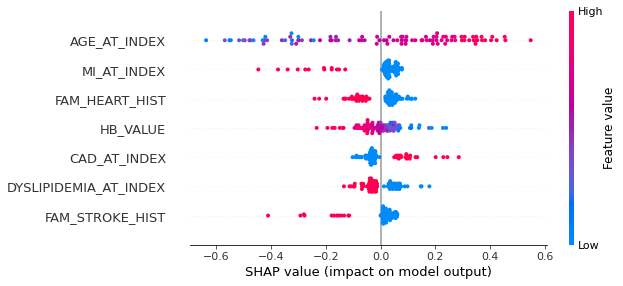

In [166]:
# X100 = shap.utils.sample(X_train_new, 100)
# explainer = shap.KernelExplainer(mlp.predict,X100, feature_names=X_train.columns)
# shap_values = explainer.shap_values(X100)
# shap.summary_plot(shap_values, X100, feature_names=X_train.columns,max_display=7, show= False,plot_type='dot')
# plt.savefig('NN_SHAP.pdf', dpi=300, format='pdf', bbox_inches='tight')
shapPlotforCV(list_test_sets,list_shap_values, X_train_new,X_train.columns,"NN_SHAP")

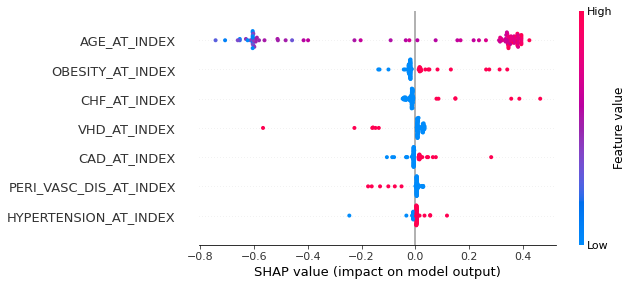

In [172]:
# X100 = shap.utils.sample(X_tr_havoc)
# explainer = shap.KernelExplainer(mlp_havoc.predict,X100, feature_names=X_train_havoc.columns)
# shap_values = explainer.shap_values(X100)
# shap.summary_plot(shap_values, X100, feature_names=X_train_havoc.columns,max_display=7, show= False,plot_type='dot')
# plt.savefig('NN_HAVOC_SHAP.pdf', dpi=300, format='pdf', bbox_inches='tight')

shapPlotforCV(list_test_sets,list_shap_values, X_tr_havoc,X_train.columns,"NN_SHAP")

# Random Forests

In [54]:
from sklearn.ensemble import RandomForestClassifier
RF={'name':'RF','accuracy':[],'sensitivity':[], 'specificity':[],'auc':[],'ppv':[],'npv':[],'mean_tpr':[],'mean_auc':[],'F1':[]}
RF_havoc={'name':'RF_havoc','accuracy':[],'sensitivity':[], 'specificity':[],'auc':[],'ppv':[],'npv':[],'mean_tpr':[],'mean_auc':[],'F1':[]}

clf = RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=50)

clf_havoc = RandomForestClassifier(max_depth=8, min_samples_leaf=10, min_samples_split=10,
                       n_estimators=10)

X, y = afib_diagnosis_pandas_limited.iloc[:,:-1],afib_diagnosis_pandas_limited.iloc[:,-1]

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
mean_tpr_havoc = 0.0
mean_fpr_havoc = np.linspace(0, 1, 100)

list_shap_values = list()
list_test_sets = list()
list_shap_values_havoc = list()

for train_ix, test_ix in kfold.split(X,y):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
    class_weights = list(class_weight.compute_class_weight('balanced',np.unique(y_train),y_train))
    w_array = np.ones(y_train.shape[0], dtype = 'float')
    for i, val in enumerate(y_train):
        w_array[i] = class_weights[val]
    
    clf.fit(X_train,y_train,sample_weight = w_array)
    prediction = clf.predict(X_test)
    
    explainer = shap.TreeExplainer(clf, X_train, feature_names=X_train.columns,feature_dependence="independent")
    shap_values = explainer.shap_values(X_tr)
    
    list_shap_values.append(shap_values)
    list_test_sets.append(train_ix)
    
    fpr, tpr, thresholds = roc_curve(y_test, prediction)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    
    RF['accuracy'].append(accuracy_score(y_test,prediction))
    RF['sensitivity'].append(recall_score(y_test,prediction))
    RF['specificity'].append(recall_score(y_test,prediction,pos_label=0))
    RF['auc'].append(roc_auc_score(y_test,prediction))
    RF['ppv'].append(precision_score(y_test,prediction))
    RF['npv'].append(precision_score(y_test,prediction,pos_label=0))
    RF['F1'].append(f1_score(y_test,prediction))
    
    X_train_havoc=X_train[['AGE_AT_INDEX','HYPERTENSION_AT_INDEX','VHD_AT_INDEX','PERI_VASC_DIS_AT_INDEX','CAD_AT_INDEX','OBESITY_AT_INDEX','CHF_AT_INDEX']]
    X_test_havoc=X_test[['AGE_AT_INDEX','HYPERTENSION_AT_INDEX','VHD_AT_INDEX','PERI_VASC_DIS_AT_INDEX','CAD_AT_INDEX','OBESITY_AT_INDEX','CHF_AT_INDEX']]
    
    clf_havoc.fit(X_train_havoc,y_train,sample_weight = w_array)
    prediction = clf_havoc.predict(X_test_havoc)
    
    explainer_havoc = shap.TreeExplainer(clf_havoc, X_train_havoc, feature_names=X_train_havoc.columns,feature_dependence="independent")
    shap_values_havoc = explainer.shap_values(X_train_havoc)
    list_shap_values_havoc.append(shap_values_havoc)
    
    fpr_havoc, tpr_havoc, thresholds_havoc = roc_curve(y_test, prediction)
    mean_tpr_havoc += interp(mean_fpr_havoc, fpr_havoc, tpr_havoc)
    mean_tpr_havoc[0] = 0.0
    
    RF_havoc['accuracy'].append(accuracy_score(y_test,prediction))
    RF_havoc['sensitivity'].append(recall_score(y_test,prediction))
    RF_havoc['specificity'].append(recall_score(y_test,prediction,pos_label=0))
    RF_havoc['auc'].append(roc_auc_score(y_test,prediction))
    RF_havoc['ppv'].append(precision_score(y_test,prediction))
    RF_havoc['npv'].append(precision_score(y_test,prediction,pos_label=0))
    RF_havoc['F1'].append(f1_score(y_test,prediction))
    
mean_tpr /= kfold.get_n_splits(X, y)
mean_tpr[-1] = 1.0
RF['mean_auc'].append(auc(mean_fpr, mean_tpr))
RF['mean_tpr'].append(mean_tpr)


mean_tpr_havoc /= kfold.get_n_splits(X, y)
mean_tpr_havoc[-1] = 1.0
RF_havoc['mean_auc'].append(auc(mean_fpr_havoc, mean_tpr_havoc))
RF_havoc['mean_tpr'].append(mean_tpr_havoc)       

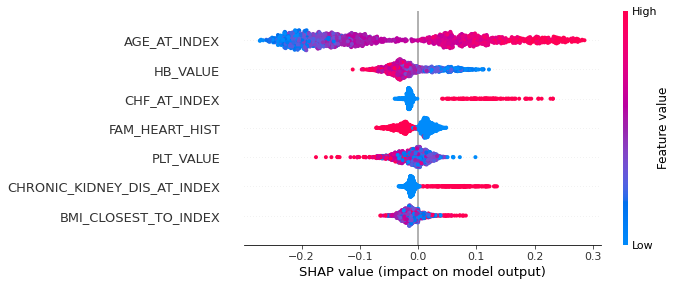

In [16]:
# explainer = shap.TreeExplainer(clf,feature_dependence="independent")
# shap_values = explainer.shap_values(X_train)
# shap.summary_plot(shap_values[1], features=X_train, feature_names=X_train.columns,max_display=7, show= False)
# plt.savefig('RF_SHAP.pdf', dpi=300, format='pdf', bbox_inches='tight')

shapPlotforCV(list_test_sets,list_shap_values, X_train,X_train.columns,"RF_SHAP")

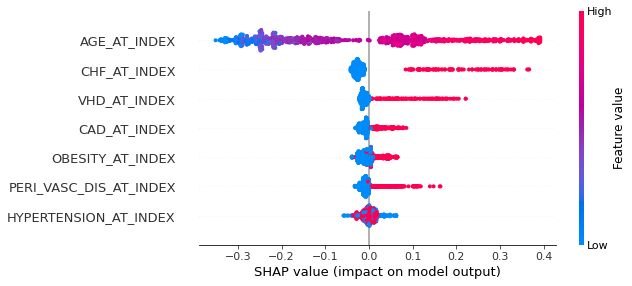

In [175]:
# explainer = shap.TreeExplainer(clf_havoc)
# shap_values = explainer.shap_values(X_train_havoc)
# shap.summary_plot(shap_values[1], features=X_train_havoc, feature_names=X_train_havoc.columns,max_display=7, show= False)
# plt.savefig('RF_HAVOC_SHAP.pdf', dpi=300, format='pdf', bbox_inches='tight')

shapPlotforCV(list_test_sets,list_shap_values_havoc, X_train_havoc,X_train_havoc.columns,"RF_havoc_SHAP")

# Havoc Risk

In [7]:
def havoc_classify(data, threshold):
    data['AFIB_THRESHOLD'] = data.apply(
        lambda row: 1 if row['HAVOC_SCORE'] > threshold else 0,
        axis =1
    )
    true_positive = 0
    true_negetive = 0
    false_positive = 0
    false_negetive = 0

    for j in range(0,len(data['AFIB_THRESHOLD'])):
        if data['AFIB_THRESHOLD'].iloc[j] == 1:
            if data['AFIB_DIAGNOSED'].iloc[j] == 1:
                true_positive += 1
            else:
                false_positive += 1
        else:
            if data['AFIB_DIAGNOSED'].iloc[j] == 0:
                true_negetive += 1
            else:
                false_negetive += 1

    accuracy = (true_positive + true_negetive)/ (true_positive + true_negetive + false_positive + false_negetive)

    sensitivity,specificity = true_positive/(true_positive+false_negetive),true_negetive/(true_negetive+false_positive)
    ppv,npv = true_positive/(true_positive+false_positive),true_negetive/(true_negetive+false_negetive)
    f1 = 2 * (sensitivity * ppv) /(sensitivity + ppv)
    #print(true_positive, false_negetive,false_positive, true_negetive)
    return accuracy, sensitivity, specificity, ppv,npv, f1


In [8]:
HAVOC_3={'name':'HAVOC_3','accuracy':[],'sensitivity':[], 'specificity':[],'ppv':[],'npv':[],'F1':[]}
HAVOC_4={'name':'HAVOC_4','accuracy':[],'sensitivity':[], 'specificity':[],'ppv':[],'npv':[],'F1':[]}
HAVOC_5={'name':'HAVOC_5','accuracy':[],'sensitivity':[], 'specificity':[],'ppv':[],'npv':[],'F1':[]}
X, y = afib_diagnosis_pandas_limited.iloc[:,:-1],afib_diagnosis_pandas_limited.iloc[:,-1]
for train_ix, test_ix in kfold.split(X,y):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
    test_havoc= X_test.copy()
    test_havoc['AGE_SCORE'] = test_havoc.apply(
        lambda row: 2 if row['AGE_AT_INDEX'] >= 75 else 0,
        axis =1
    ) 
    test_havoc['HAVOC_SCORE'] = test_havoc['AGE_SCORE']+ 2 * test_havoc['HYPERTENSION_AT_INDEX'] + 2 * test_havoc['VHD_AT_INDEX'] + test_havoc['PERI_VASC_DIS_AT_INDEX']+ test_havoc['OBESITY_AT_INDEX'] + 2 * test_havoc['CAD_AT_INDEX'] + 4* test_havoc['CHF_AT_INDEX']
    test_havoc['AFIB_DIAGNOSED'] =  y_test

    test_havoc['HAVOC_RISK_SCORE'] = test_havoc.apply(
        lambda row: 'low(0-4)' if row['HAVOC_SCORE'] <=4 else 'medium(5-9)' if  row['HAVOC_SCORE'] >=5 and row['HAVOC_SCORE'] <=9 else 'high(10-14)',
        axis =1
    ) 
    
    acc3, sen3, spec3,ppv3,npv3,f13 = havoc_classify(test_havoc, 3) 
    HAVOC_3['accuracy'].append(acc3)
    HAVOC_3['sensitivity'].append(sen3)
    HAVOC_3['specificity'].append(spec3)
    HAVOC_3['ppv'].append(ppv3)
    HAVOC_3['npv'].append(npv3)
    HAVOC_3['F1'].append(f13)
    
    acc4, sen4, spec4,ppv4,npv4,f14 = havoc_classify(test_havoc, 4)
    HAVOC_4['accuracy'].append(acc4)
    HAVOC_4['sensitivity'].append(sen4)
    HAVOC_4['specificity'].append(spec4)
    HAVOC_4['ppv'].append(ppv4)
    HAVOC_4['npv'].append(npv4)
    HAVOC_4['F1'].append(f14)
    
    acc5, sen5, spec5,ppv5,npv5,f15 = havoc_classify(test_havoc, 5)
    HAVOC_5['accuracy'].append(acc5)
    HAVOC_5['sensitivity'].append(sen5)
    HAVOC_5['specificity'].append(spec5)
    HAVOC_5['ppv'].append(ppv5)
    HAVOC_5['npv'].append(npv5)
    HAVOC_5['F1'].append(f15)
    

3
['HAVOC_3', 'HAVOC_4', 'HAVOC_5'] [1.8 5.8 9.8]
sensitivity [1.8 5.8 9.8]
sensitivity 0.6380489242558208 0.5751995425655995 0.7008983059460422
sensitivity 0.46146478043029765 0.3928867938664458 0.5300427669941494
sensitivity 0.3345564397288535 0.29563256368604585 0.3734803157716612
specificity [ 2.6  6.6 10.6]
specificity 0.6440145067415401 0.6100021586109078 0.6780268548721725
specificity 0.793732268725688 0.7798227720995343 0.8076417653518417
specificity 0.8815682489544032 0.8514031756933609 0.9117333222154456
npv [ 3.4  7.4 11.4]
npv 0.8001153116513072 0.7712483454109128 0.8289822778917016
npv 0.7682903810579562 0.7463080745663275 0.7902726875495849
npv 0.7484457919168781 0.7390040468562348 0.7578875369775214
F1 [ 4.2  8.2 12.2]
F1 0.5233254234533624 0.4811562883464325 0.5654945585602924
F1 0.4784889852465485 0.4255228856253907 0.5314550848677062
F1 0.4175405024822212 0.3878046668895069 0.4472763380749355


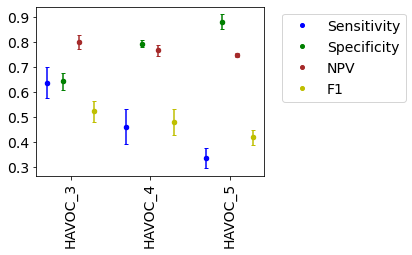

In [14]:
HAVOC_RISK = [HAVOC_3,HAVOC_4,HAVOC_5]
name_list=[]
for ml in HAVOC_RISK:
    name_list.append(ml['name']) 
plotCI(HAVOC_RISK,name_list) 

# plot

In [9]:
from statistics import mean
import matplotlib.pyplot as plt
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [19]:
ML = [LR, LR_OS, XGB,SV, SVG, CB,NN, RF]
ML_havoc = [LR_havoc, LR_havoc_OS, XGB_havoc, SV_havoc, SVG_havoc, CB_havoc,NN_havoc, RF_havoc]
name_list=[]
for ml in ML:
    name_list.append(ml['name']) 

In [13]:
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [10]:
attr_set = ['sensitivity','specificity','npv','F1']
            
def plotCI(ML,name_list):
    sensitivity =[]
    specificity =[]
    F1 =[]
    npv =[]
    
    x_old = np.arange(3, 4*(len(ML)),4)
    x = np.arange(1.8, 4*(len(ML)),4)
    count = 0
    
    x_ticks = name_list   
    
    fig, ax1 = plt.subplots(1, 1, figsize=set_size('thesis'))

    colors = ["b","g","brown","y"]
    l= 0
    
    scale_factor = 5

    for attr in attr_set:
        print(attr,x)
        y = []
        err = []
        if attr=='npv':
            lab = attr.upper()
        else:
            lab = attr.capitalize()
        for ml in ML:
            y.append(mean(ml[attr]))
            err.append(mean_confidence_interval(ml[attr]))
        ax1.scatter(x, y, c=colors[l], s=20, zorder=3)

        ax1.errorbar(x, y, err, capsize=2,color=colors[l],
              linestyle="None",
              marker="o", markersize=4,label=lab)   
        l+=1
        x = x + 0.8
   
    handles, labels = ax1.get_legend_handles_labels()
    handles = [h[0] for h in handles]
    ax1.legend(handles, labels, loc='upper left',numpoints=1,prop={'size':14},bbox_to_anchor=(1.05, 1))
 
    plt.xticks(x_old, x_ticks, rotation=90)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()
#     fig.savefig('images\\new\\ml_all_havoc.pdf', format='pdf', bbox_inches='tight')


In [57]:
HAVOC_RISK = [HAVOC_3,HAVOC_4,HAVOC_5]
import inspect
def plotCIgraph(ML,attr):
    plt.style.use('seaborn-white')
    x = []
    y = []
    err = []
    colors = ["b","g","c","m","y","k","r",'brown']
    cols = colors[:len(ML)]
    for ml in ML:
        x.append(ml['name'])
        y.append(mean(ml[attr]))
        err.append(mean_confidence_interval(ml[attr]))
        a= mean(ml[attr])-mean_confidence_interval(ml[attr])
        b=mean(ml[attr])+mean_confidence_interval(ml[attr])
        
        print(ml['name'],': ',"{:.3f}".format(mean(ml[attr])),'[' +"{:.3f}".format(mean(ml[attr])-mean_confidence_interval(ml[attr]))+', '+"{:.3f}".format(mean(ml[attr])+mean_confidence_interval(ml[attr]))+']')
    plt.scatter(x, y, c=cols, s=50, zorder=3)
    plt.errorbar(x, y, yerr=err, fmt='.k', mfc='red',
         mec='green')    
    plt.xticks(rotation =90,fontsize=14)
    plt.yticks(fontsize=14)
#     plt.savefig('images\\new\\ml_havoc_'+attr +'.png', format='png',dpi=1200,bbox_inches='tight')

LR_havoc :  0.717 [0.705, 0.728]
LR_OS_havoc :  0.708 [0.687, 0.730]
XGB_havoc :  0.669 [0.629, 0.709]
SVM_havoc(L) :  0.727 [0.707, 0.748]
SVM_havoc(G) :  0.703 [0.673, 0.734]
CB_havoc :  0.592 [0.538, 0.646]
NN_havoc :  0.714 [0.691, 0.736]
RF_havoc :  0.690 [0.666, 0.713]


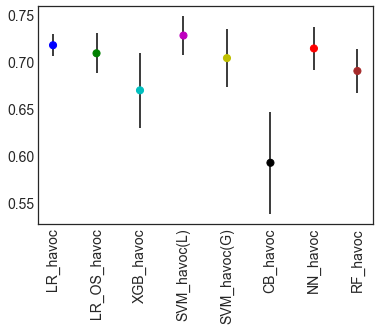

In [70]:
plotCIgraph(ML_havoc,'sensitivity') 

LR_havoc :  0.7169613910993221 0.7054744479740486 0.7284483342245957
LR_OS_havoc :  0.7083996463306809 0.6870149609198819 0.7297843317414798
XGB_havoc :  0.6689655172413793 0.629065232263556 0.7088658022192026
SVM_havoc(L) :  0.7272620100206307 0.7066107575456525 0.747913262495609
SVM_havoc(G) :  0.7032567049808429 0.6725887341161105 0.7339246758455753
CB_havoc :  0.5918950781019746 0.5376402726718585 0.6461498835320907
NN_havoc :  0.713527851458886 0.6909247777890521 0.7361309251287198
RF_havoc :  0.6895520188623637 0.6657836919233738 0.7133203458013536


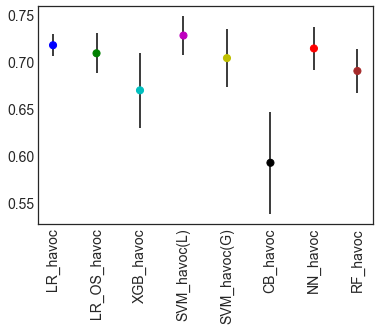

In [25]:
plotCIgraph(ML_havoc,'sensitivity') 

LR_havoc :  0.6875493550934456 0.6566191538654144 0.7184795563214769
LR_OS_havoc :  0.6768506332075692 0.650726490976017 0.7029747754391215
XGB_havoc :  0.7150682928255974 0.6632715091501403 0.7668650765010544
SVM_havoc(L) :  0.6745664063642479 0.6311646604894542 0.7179681522390416
SVM_havoc(G) :  0.694416659354801 0.6571503676511943 0.7316829510584077
CB_havoc :  0.7158228773653885 0.6847994261509206 0.7468463285798564
NN_havoc :  0.6715100465034658 0.6394727720555603 0.7035473209513713
RF_havoc :  0.7020356234096692 0.6620963714846643 0.7419748753346741


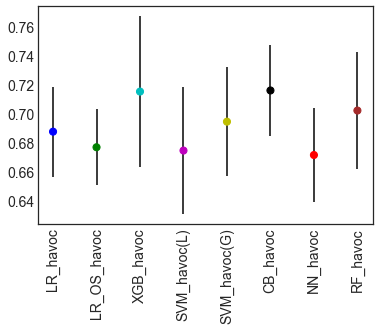

In [24]:
plotCIgraph(ML_havoc,'specificity') 

In [21]:
mean(SV_havoc['npv'])

0.8471180122884828

0.7150653680793191 0.6884356929559796 0.7416950432026586
0.7112573484250241 0.682783225291025 0.7397314715590232
0.7479073440379047 0.7317318332693032 0.7640828548065062
0.7005586265391477 0.6578565903911592 0.7432606626871362
0.6661519113216928 0.6365193458291613 0.6957844768142244
0.8303851890848469 0.8019689153472646 0.8588014628224293
0.7677839197449621 0.7260855588534169 0.8094822806365073
0.7975695358427657 0.775827618535702 0.8193114531498293


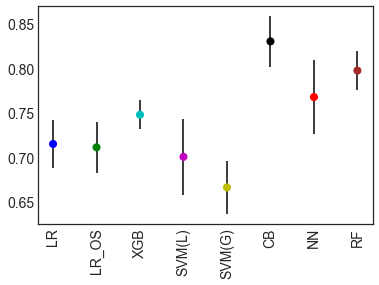

In [61]:
plotCIgraph(ML,'specificity') 

0.5931612484801648 0.5732863341704242 0.6130361627899055
0.579253396586719 0.5626398754922354 0.5958669176812027
0.5800751045602304 0.5418446193386466 0.6183055897818142
0.5922506689871639 0.5631917462275161 0.6213095917468118
0.5889651803428619 0.5597149365092546 0.6182154241764692
0.5309482310679842 0.48239959088230483 0.5794968712536634
0.5792006406560569 0.5633390761588277 0.5950622051532861
0.5925152582728629 0.5673830648879125 0.6176474516578133


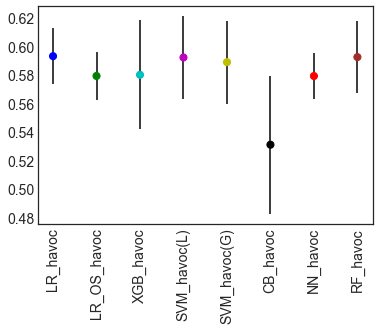

In [64]:
plotCIgraph(ML_havoc,'F1') 

In [44]:
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [343]:
import seaborn as sns
sns.set(font_scale = 1.5)
sns.set_style("white")
def boxplotviewgroupedbyML(ML):
    name =[]
    for ml in ML:
        n = [ml['name']]*5
        name += n
    data = {'sensitivity' : [j for ml in ML for j in ml['sensitivity']],
            'specificity' : [j for ml in ML for j in ml['specificity']],
            'accuracy' : [j for ml in ML for j in ml['accuracy']],
            'ppv' : [j for ml in ML for j in ml['ppv']],
            'npv' : [j for ml in ML for j in ml['npv']],
            'f1' : [j for ml in ML for j in ml['F1']],
            'cls' : name
           }
    df = pd.DataFrame(data)
    df_melt = df.melt(id_vars = 'cls',
                  value_vars = [
                                'sensitivity',
                                'specificity',
                                #'accuracy',
                                #'ppv',
                                'npv',
                                'f1'
                                ],
                  var_name = 'Measures')
    fig = plt.figure(figsize=(8,8))
    b = sns.boxplot(data = df_melt,
                hue = 'cls', 
                x = 'Measures',
                y = 'value',
                order = ['sensitivity',
                         'specificity',
                         #'accuracy',
                         #'ppv',
                         'npv',
                         'f1'],width=0.8)

    b.set_xticklabels(b.get_xticklabels(),rotation=30)
    b.legend(prop={'size':13},bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title('Boxplot grouped by cls')
    adjust_box_widths(fig, 0.6)
    plt.savefig('images\\new\\ml_havoc_boxplot_grouped.png', format='png',dpi=1200,bbox_inches='tight')
    plt.show()

    

    
def boxplotview(ML):
    name =[]
    for ml in ML:
        n = [ml['name']]*5
        name += n
    data = {'sensitivity' : [j for ml in ML for j in ml['sensitivity']],
            'specificity' : [j for ml in ML for j in ml['specificity']],
            'accuracy' : [j for ml in ML for j in ml['accuracy']],
            'ppv' : [j for ml in ML for j in ml['ppv']],
            'npv' : [j for ml in ML for j in ml['npv']],
            'f1' : [j for ml in ML for j in ml['F1']],
            'ml_algorithms' : name
           }
    df = pd.DataFrame(data)
    df_melt = df.melt(id_vars = 'ml_algorithms',
                  value_vars = ['sensitivity',
                                'specificity',
                                #'accuracy',
                                #'ppv',
                                'npv',
                                'f1'],
                  var_name = 'columns')
    #fig2 = plt.figure(figsize=(10,10))
    g = sns.factorplot(data = df_melt,
                   x = 'ml_algorithms',
                   y = 'value',
                   kind = 'box', 
                   col = 'columns',
                   col_order = ['sensitivity',
                                'specificity',
                                #'accuracy',
                                #'ppv',
                                'npv',
                                'f1']).set_titles('{col_name}') 
    g.set_xticklabels(rotation=90)
    #plt.savefig('images\\ml_havoc_boxplot.png', format='png',dpi=1200,bbox_inches='tight')
    plt.show()
    

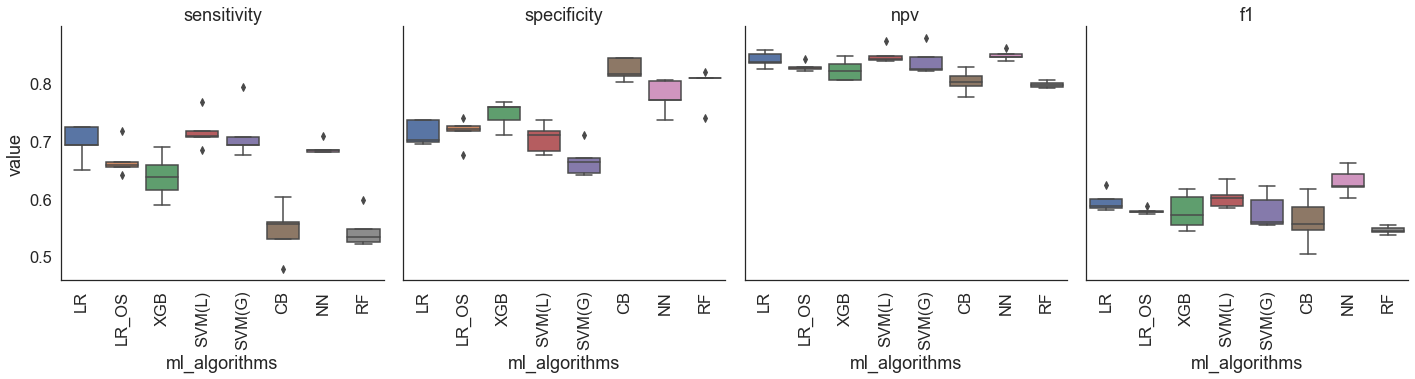

In [32]:
boxplotview(ML)

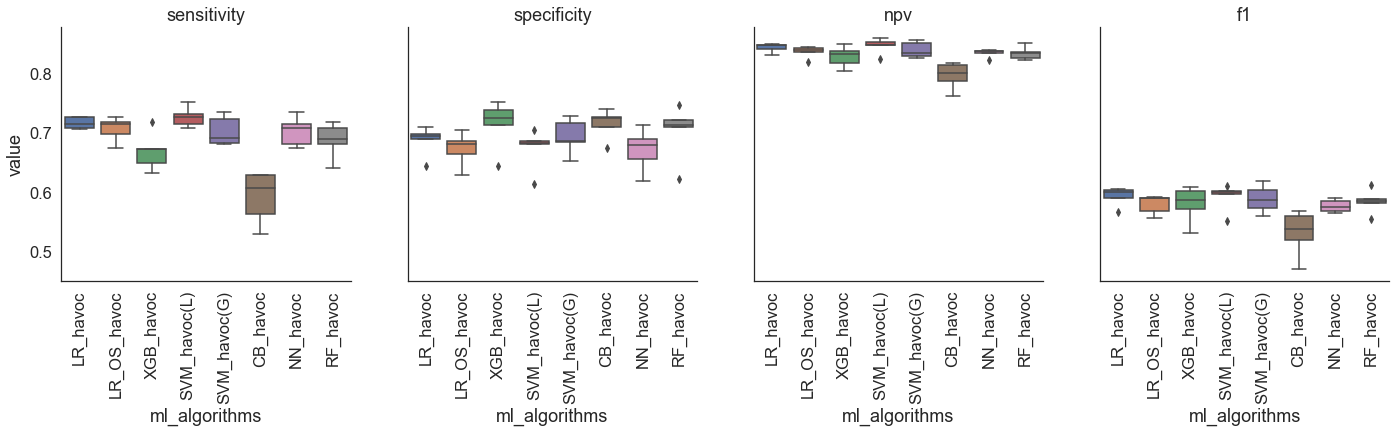

In [34]:
boxplotview(ML_havoc)

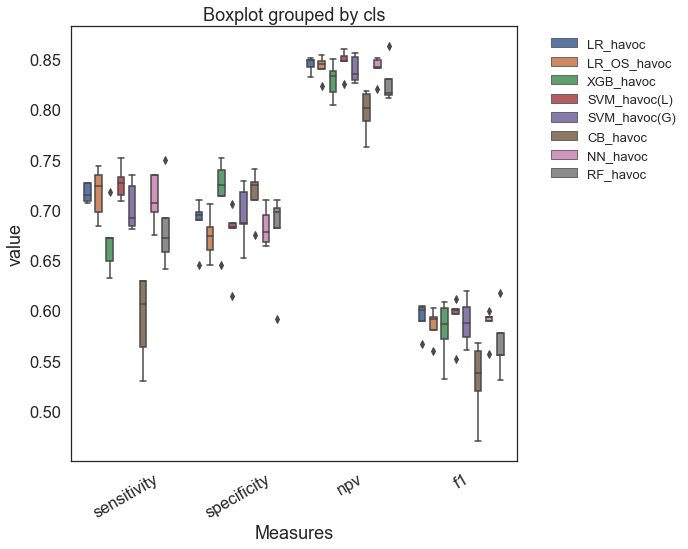

In [344]:
boxplotviewgroupedbyML(ML_havoc)

In [338]:
sns.set(font_scale = 1.5)
sns.set_style("white")
def scatterplotviewgroupedbyML(ML):
    name =[]
    for ml in ML:
        n = [ml['name']]*5
        name += n
        print(name)
    data = {'sensitivity' : [j for ml in ML for j in ml['sensitivity']],
            'specificity' : [j for ml in ML for j in ml['specificity']],
            'accuracy' : [j for ml in ML for j in ml['accuracy']],
            'ppv' : [j for ml in ML for j in ml['ppv']],
            'npv' : [j for ml in ML for j in ml['npv']],
            'f1' : [j for ml in ML for j in ml['F1']],
            'cls' : name
           }
    df = pd.DataFrame(data)
    print(df)
    df_melt = df.melt(id_vars = ['cls'],
                  value_vars = [
                                'sensitivity',
                                'specificity',
                                #'accuracy',
                                #'ppv',
                                'npv',
                                'f1'
                                ])
    df_melt["hue"] = df_melt.groupby(["cls"]).cumcount()

    fig = plt.figure(figsize=(8,8))
    b = sns.boxplot(data = df_melt,
                hue = 'hue', 
                x = 'cls',
                y = 'value',
                showbox =False,
                width=0.8)

    b.set_xticklabels(b.get_xticklabels(),rotation=30)
    b.legend(prop={'size':13},bbox_to_anchor=(1.05, 1), loc='upper left')
    #sns.despine(offset=0.01, trim=True)
    plt.title('Boxplot grouped by cls')
    adjust_box_widths(fig, 0.6)
    plt.savefig('images\\new\\ml_boxplot_grouped.png', format='png',dpi=1200,bbox_inches='tight')
    plt.show()
    #plt.show()
    

[0.6837606837606838,
 0.6837606837606838,
 0.6666666666666666,
 0.7327586206896551,
 0.7241379310344828]

['LR', 'LR', 'LR', 'LR', 'LR']
['LR', 'LR', 'LR', 'LR', 'LR', 'LR_OS', 'LR_OS', 'LR_OS', 'LR_OS', 'LR_OS']
['LR', 'LR', 'LR', 'LR', 'LR', 'LR_OS', 'LR_OS', 'LR_OS', 'LR_OS', 'LR_OS', 'XGB', 'XGB', 'XGB', 'XGB', 'XGB']
['LR', 'LR', 'LR', 'LR', 'LR', 'LR_OS', 'LR_OS', 'LR_OS', 'LR_OS', 'LR_OS', 'XGB', 'XGB', 'XGB', 'XGB', 'XGB', 'SVM(L)', 'SVM(L)', 'SVM(L)', 'SVM(L)', 'SVM(L)']
['LR', 'LR', 'LR', 'LR', 'LR', 'LR_OS', 'LR_OS', 'LR_OS', 'LR_OS', 'LR_OS', 'XGB', 'XGB', 'XGB', 'XGB', 'XGB', 'SVM(L)', 'SVM(L)', 'SVM(L)', 'SVM(L)', 'SVM(L)', 'SVM(G)', 'SVM(G)', 'SVM(G)', 'SVM(G)', 'SVM(G)']
['LR', 'LR', 'LR', 'LR', 'LR', 'LR_OS', 'LR_OS', 'LR_OS', 'LR_OS', 'LR_OS', 'XGB', 'XGB', 'XGB', 'XGB', 'XGB', 'SVM(L)', 'SVM(L)', 'SVM(L)', 'SVM(L)', 'SVM(L)', 'SVM(G)', 'SVM(G)', 'SVM(G)', 'SVM(G)', 'SVM(G)', 'CB', 'CB', 'CB', 'CB', 'CB']
['LR', 'LR', 'LR', 'LR', 'LR', 'LR_OS', 'LR_OS', 'LR_OS', 'LR_OS', 'LR_OS', 'XGB', 'XGB', 'XGB', 'XGB', 'XGB', 'SVM(L)', 'SVM(L)', 'SVM(L)', 'SVM(L)', 'SVM(L)', 'SVM(G)'

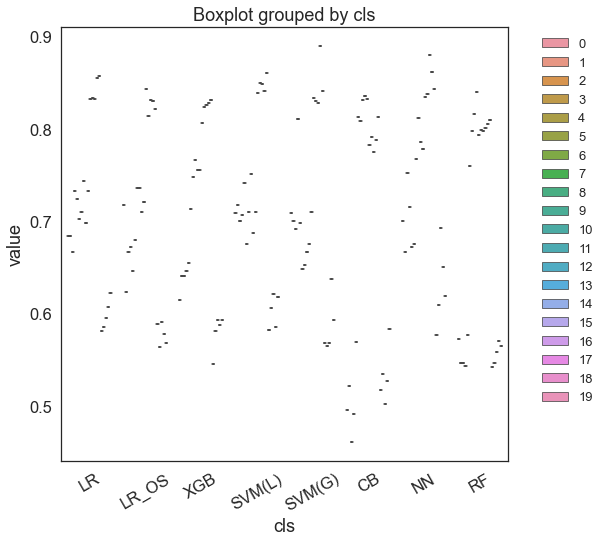

In [339]:
scatterplotviewgroupedbyML(ML)

In [37]:
def auc_curve(ML):
    lw = 2
    colors = ["b","g","c","m","y","k","r",'brown']
    i=0
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax1 = plt.subplots(1, 1, figsize=set_size('thesis'))
    for ml in ML:
        print (ml['name']+ ' : Mean ROC (area = %0.3f)' % ml['mean_auc'][0])
        plt.plot(mean_fpr, 
             ml['mean_tpr'][0], lw=lw, color=colors[i],
             label= ml['name'].replace('_havoc','') )
        i+=1
    plt.plot([0,1], [0,1], color='orange', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.2))
    plt.xlabel("False Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.2))
    plt.ylabel("True Positive Rate", fontsize=15)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)

)
    plt.legend(prop={'size':13},bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
#     plt.savefig('images\\new\\ml_auc_modified.png', format='png',dpi=1200,bbox_inches='tight')
    #fig.savefig('images\\new\\ml_havoc_auc.pdf', format='pdf', bbox_inches='tight')
    plt.show()    

LR_havoc : Mean ROC (area = 0.702)
LR_OS_havoc : Mean ROC (area = 0.693)
XGB_havoc : Mean ROC (area = 0.692)
SVM_havoc(L) : Mean ROC (area = 0.701)
SVM_havoc(G) : Mean ROC (area = 0.699)
CB_havoc : Mean ROC (area = 0.654)
NN_havoc : Mean ROC (area = 0.693)
RF_havoc : Mean ROC (area = 0.696)


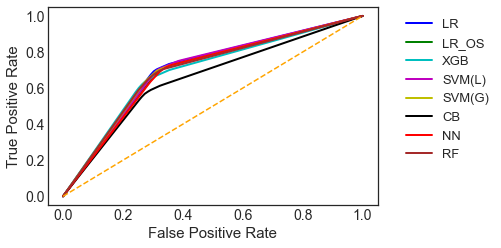

In [38]:
auc_curve(ML_havoc)

LR : Mean ROC (area = 0.708)
LR_OS : Mean ROC (area = 0.694)
XGB : Mean ROC (area = 0.688)
SVM(L) : Mean ROC (area = 0.707)
SVM(G) : Mean ROC (area = 0.695)
CB : Mean ROC (area = 0.673)
NN : Mean ROC (area = 0.733)
RF : Mean ROC (area = 0.670)


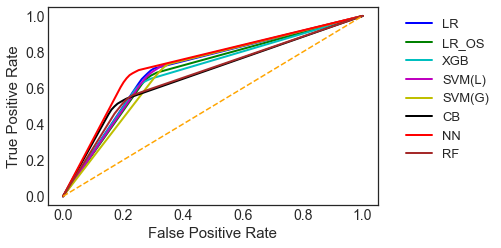

In [39]:
auc_curve(ML)

#plt.plot(mean_fpr,LR['mean_tpr'])
#mean_fpr.shape,LR['mean_tpr'][0].shape

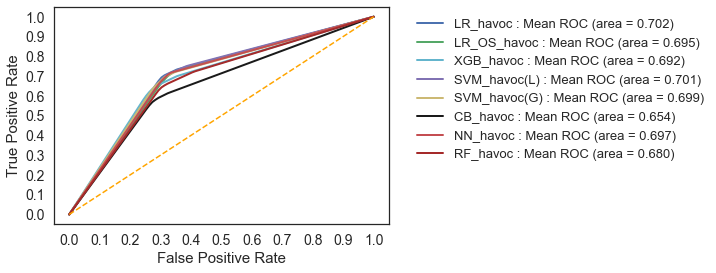

In [345]:
auc_curve(ML_havoc)

# Significance Comparison among models (7 Havoc vs 27 clinically approved vars)

In [ ]:
def significance(model1, model2, X,y):
    #model1: model with 27 vars
    #model2: model with 7 HAVOC vars 
    scoring=[make_scorer(roc_auc_score),make_scorer(recall_score),make_scorer(recall_score,pos_label=0),make_scorer(precision_score,pos_label=0),make_scorer(f1_score)]
    measure_name=['AUC','Sensitivity','Specificity','NPV','F1 score']
    for i in range(len(measure_name)):
        t, p = paired_ttest_5x2cv(estimator1=model1, estimator2=model2, X=X, y=y, scoring=scoring[i], random_seed=1)
        print("Result of significance for ", measure_name[i])
        print('================================')
        print('P-value: %.3f \n t-Statistic: %.3f' % (p, t))
    return

# SHAP calcualtion and plotting

In [ ]:
def shapPlotforCV(list_test_sets,list_shap_values, X,columns,name):
    test_set = list_test_sets[0]
    shap_values = np.array(list_shap_values[0])
    for i in range(1,len(list_test_sets)):
        test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
        shap_values = np.concatenate((shap_values,np.array(list_shap_values[i])),axis=1)
    #bringing back variable names    
    X_test = pd.DataFrame(X[test_set],columns=columns)
    shap.summary_plot(shap_values[1], X_test, feature_names=columns,show= False,max_display=7)
    plt.savefig(name+'.pdf', dpi=300, format='pdf', bbox_inches='tight')